In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

In [39]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

path = '../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2'] # plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura.to_csv('data/aggregated_cpm.csv')

info = [['data/social_origins/china_top_1500.csv','Chinese world'], 
 ['data/social_origins/italy_top_1500.csv','Italy'],
['data/social_origins/uk_top_1701.csv','United Kingdom'],
['data/social_origins/japan_top_1500.csv','Japan']]




In [40]:
df_cultura

,region_name,decade,N_est,score
0,Arabic world,-610,5.529170,1
1,Arabic world,-400,2.611448,1
2,Arabic world,-360,14.825990,3
3,Arabic world,-330,6.061846,1
4,Arabic world,-310,6.022250,1
...,...,...,...,...
2393,United Kingdom,1840,12298.471136,936
2394,United Kingdom,1850,12344.101231,909
2395,United Kingdom,1860,15480.038693,1144
2396,United Kingdom,1870,11764.644742,912


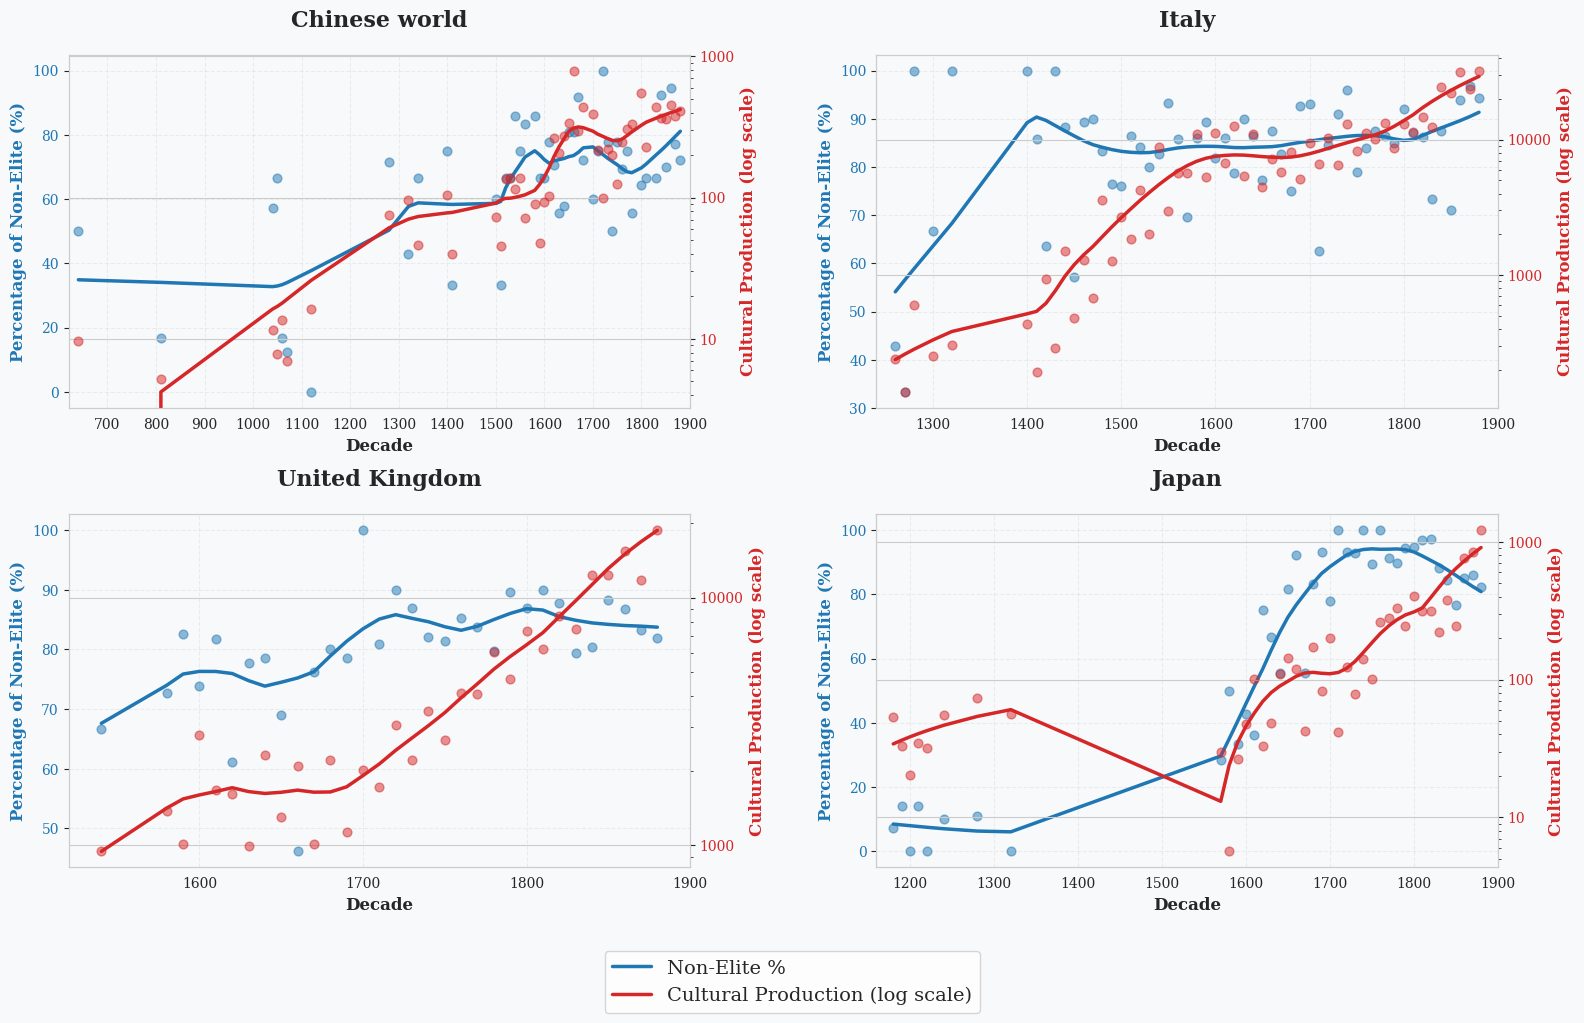

In [41]:
# Set a beautiful style for the whole figure
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12, 
    'font.family': 'serif',
    'font.weight': 'normal',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Create a figure with 4 subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Define consistent colors
color_non_elite = '#1f77b4'  # blue
color_cpm = '#d62728'  # red

# Process each region in its own subplot
for i, region in enumerate(info[:4]):  # Assuming info has at least 4 regions
    # Get the current axis
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    df_region = pd.read_csv('../2-cultura_database_extract/' + region[0], index_col = [0])
    df_region =df_region.head(1500)

    df_info = pd.read_csv('../2-cultura_database_extract/db_extract/df_individuals_score.csv')
    df_info = df_info[['individual_wikidata_id', 'decade']].drop_duplicates()

    df_region = pd.merge(df_info, df_region, on = 'individual_wikidata_id')
    df_region = df_region.rename(columns={'country':'region_name'})
    df_region = df_region[['region_name', 'classification', 'decade']]
    df_region['region_name'] =  region[1]

    df_region = df_region.dropna()

    # Starting with your existing dataframe (df_region)
    df = df_region.copy()

    # Converting 'decade' to numeric, handling NaN values
    df['decade'] = pd.to_numeric(df['decade'], errors='coerce')

    # Filtering out rows with NaN decade values
    df = df.dropna(subset=['decade'])

    # Creating a new column to identify non-elite rows (everything except 'Elite')
    df['non_elite'] = df['classification'] != 'Elite'

    # Grouping by region_name AND decade, then counting non-elite entries
    region_decade_counts = df.groupby(['region_name', 'decade'])['non_elite'].sum().reset_index()

    # Calculate total counts per region and decade
    region_decade_totals = df.groupby(['region_name', 'decade']).size().reset_index(name='total')

    # Merge counts with totals
    result_df = region_decade_counts.merge(region_decade_totals, on=['region_name', 'decade'])

    # Calculate percentage of non-elite entries
    result_df['percentage'] = (result_df['non_elite'] / result_df['total']) * 100

    # Filter to include only groups with more than 5 entries
    result_df = result_df[result_df['total'] > 5]

    # Sort by region_name and decade for better readability
    result_df = result_df.sort_values(['region_name', 'decade'])

    df_final = pd.merge(result_df, df_cultura, on = ['region_name', 'decade'])
    df_final = df_final[['region_name', 'decade', 'percentage', 'N_est']].copy()

    # Sort data by decade for proper visualization
    df_sorted = df_final.sort_values('decade')

    # Calculate LOWESS trend for percentage
    lowess_percentage = lowess(df_sorted['percentage'], df_sorted['decade'], frac=0.3, it=1)
    trend_x_percentage = lowess_percentage[:, 0]
    trend_y_percentage = lowess_percentage[:, 1]

    # Calculate LOWESS trend for N_est
    lowess_nest = lowess(df_sorted['N_est'], df_sorted['decade'], frac=0.3, it=1)
    trend_x_nest = lowess_nest[:, 0]
    trend_y_nest = lowess_nest[:, 1]

    # Plot percentage data and trend line on the primary y-axis with consistent colors
    ax1.scatter(df_sorted['decade'], df_sorted['percentage'], color=color_non_elite, s=40, alpha=0.5)
    ax1.plot(trend_x_percentage, trend_y_percentage, color=color_non_elite, linestyle='-', linewidth=2.5)

    ax1.set_xlabel('Decade', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Percentage of Non-Elite (%)', color=color_non_elite, fontsize=12, fontweight='bold')
    ax1.tick_params(axis='y', labelcolor=color_non_elite)

    # Set log scale for CPM axis
    ax2.set_yscale('log')
    
    # Plot N_est data and trend line on the secondary y-axis (log scale)
    ax2.scatter(df_sorted['decade'], df_sorted['N_est'], color=color_cpm, s=40, alpha=0.5)
    ax2.plot(trend_x_nest, trend_y_nest, color=color_cpm, linestyle='-', linewidth=2.5)

    ax2.set_ylabel('Cultural Production (log scale)', color=color_cpm, fontsize=12, fontweight='bold')
    ax2.tick_params(axis='y', labelcolor=color_cpm)
    
    # Format the log scale with more readable tick labels
    from matplotlib.ticker import LogFormatter
    formatter = LogFormatter(10, labelOnlyBase=False)
    ax2.yaxis.set_major_formatter(formatter)

    # Set ticks for appropriate decades
    min_decade = min(df_final['decade'])
    max_decade = max(df_final['decade'])
    # Round to nearest 100 below and above
    start_decade = (min_decade // 100) * 100
    end_decade = ((max_decade // 100) + 1) * 100
    ticks = np.arange(start_decade, end_decade + 100, 100)
    ax1.set_xticks(ticks)
    ax1.set_xlim(min_decade - 20, max_decade + 20)

    # Add title for each subplot
    ax1.set_title(f"{region[1]}", fontsize=16, fontweight='bold', pad=20)

    # Improve grid appearance
    ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Calculate correlation using log of N_est for better comparison with percentage values
    # This gives a more meaningful correlation when using log scale
    df_final_corr = df_final.copy()
    df_final_corr['N_est_log'] = np.log10(df_final_corr['N_est'].apply(lambda x: max(x, 0.001)))

    
    # Add subtle background color for better contrast
    ax1.set_facecolor('#f8f9fa')

# Create unified legend for the entire figure
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=color_non_elite, lw=2.5, label='Non-Elite %'),
    Line2D([0], [0], color=color_cpm, lw=2.5, label='Cultural Production (log scale)')
]
fig.legend(handles=legend_elements, loc='upper center', fontsize=14, 
          frameon=True, bbox_to_anchor=(0.5, 0.02))

# Add subtle background color for better contrast
fig.patch.set_facecolor('#f8f9fa')

# Adjust layout to avoid overlapping
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the figure
plt.show()

In [42]:
final_list = []

# Process each region in its own subplot
for i, region in enumerate(info[:4]):  # Assuming info has at least 4 regions
    # Get the current axis
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    df_region = pd.read_csv('../2-cultura_database_extract/' + region[0], index_col = [0])
    df_region =df_region.head(1500)

    df_info = pd.read_csv('../2-cultura_database_extract/db_extract/df_individuals_score.csv')
    df_info = df_info[['individual_wikidata_id', 'decade']].drop_duplicates()

    df_region = pd.merge(df_info, df_region, on = 'individual_wikidata_id')
    df_region = df_region.rename(columns={'country':'region_name'})
    df_region = df_region[['region_name', 'classification', 'decade']]
    df_region['region_name'] =  region[1]

    df_region = df_region.dropna()

    # Starting with your existing dataframe (df_region)
    df = df_region.copy()
    final_list.append(df)

final_df = pd.concat([x for x in final_list])
final_df


,region_name,classification,decade
0,Chinese world,Middle Class,1590
1,Chinese world,Middle Class,1780
2,Chinese world,Elite,1600
3,Chinese world,Middle Class,1870
4,Chinese world,Middle Class,1650
...,...,...,...
1489,Japan,Middle Class,1790
1490,Japan,Middle Class,1760
1491,Japan,Subsistence,1820
1493,Japan,Middle Class,1840


In [43]:
final_df = final_df.reset_index(drop=True)


final_df.to_csv('../2-cultura_database_extract/data/social_origins/final_social_origins.csv')